# Introduction to Kaggle Titanic Competition
In this project, I will be looking at Kaggle Titanic Competition and submitting my piece of code. Kaggle is a site where people create algorithms and compete against machine learning practitioners around the world. Your algorithm wins if it's the most accurate on a particular data set. 

To begin the problem we have to think logically about the columns and what we're trying to predict. What variables might logically affect the outcome of survival? Reading more about the Titanic disaster might help you with this.

We know that women and children were more likely to survive, so Age and Sex are probably good predictors. It's also logical to think that passenger class might affect the outcome, because first class cabins were closer to the deck of the ship. While fare is tied to passenger class and will probably have a strong correlation with it, it may also give us some useful information.

Family size (the number of siblings and parents/children) will probably be correlated with survival one way or the other. That's because there would either be more people to help you, or more people to think about trying to save.

There may be links between survival and columns like Ticket, Name, and Embarked (because people who boarded at certain ports may have had cabins closer or farther away from the top of the ship), .

We call this step acquiring domain knowledge, and it's fairly important to most machine learning tasks. We're looking to engineer the features so that we maximize the information we have about what we're trying to predict.

# Examining the data

In [2]:
import pandas as pd
titanic = pd.read_csv("C:/Users/Jennifer/Documents/Python/Data/titanic_train.csv")

# Print the first five rows of the dataframe
print(titanic.head(5))
print(titanic.describe())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

# Cleaning missing data
There are many ways to clean up missing data. One of the easiest is to fill in all of the missing values with the median of all the values in the column.

In [3]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

# Handling non-numeric columns
Several of our columns are non-numeric, which is a problem when it comes time to make predictions. We can't feed non-numeric columns into a machine learning algorithm and expect it to make sense of them.

We either have to exclude the non-numeric columns when we train our algorithm (Name, Sex, Cabin, Embarked, and Ticket), or find a way to convert them to numeric columns.

We'll ignore the Ticket, Cabin, and Name columns because we can't extract much information from them. Most of the values in the cabin column are missing (there are only 204 values out of a total of 891 rows), and it probably isn't a particularly informative column anyway. The Ticket and Name columns are unlikely to tell us much without some domain knowledge about what the ticket numbers mean, and about which names correlate with characteristics like large or rich families.

# Converting the Sex Column to Numeric

In [4]:
# Find all of the unique genders 
# The column appears to contain the values male and female only
print(titanic["Sex"].unique())

# Replace all the occurences of male with the number 0
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

['male' 'female']


# Repeating the same for the embarked column

In [5]:
# Find all of the unique values for "Embarked"
print(titanic["Embarked"].unique())
titanic["Embarked"] = titanic["Embarked"].fillna("S")

titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

['S' 'C' 'Q' nan]


# Making predictions using Scikit Learn

In [6]:
# Import the linear regression class
from sklearn.linear_model import LinearRegression
# Sklearn also has a helper that makes it easy to do cross-validation
from sklearn.cross_validation import KFold

# The columns we'll use to predict the target
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm class
alg = LinearRegression()
# Generate cross-validation folds for the titanic data set
# It returns the row indices corresponding to train and test
# We set random_state to ensure we get the same splits every time we run this
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    # The predictors we're using to train the algorithm  
    # Note how we only take the rows in the train folds
    train_predictors = (titanic[predictors].iloc[train,:])
    # The target we're using to train the algorithm
    train_target = titanic["Survived"].iloc[train]
    # Training the algorithm using the predictors and target
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)

c:\users\jennifer\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Evaluating Prediction Errors

In [22]:
import numpy as np

# The predictions are in three separate NumPy arrays  
# Concatenate them into a single array, along the axis 0 (the only 1 axis) 
predictions = np.concatenate(predictions, axis=0)

# Map predictions to outcomes (the only possible outcomes are 1 and 0)
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)


ValueError: zero-dimensional arrays cannot be concatenated

# Logistic Regression
We have our first predictions! With only 78.3% accuracy, though, they aren't very good. Instead, we can use logistic regression to output values between 0 and 1.

Logistic regression takes the output of a linear regression and maps it to a probability value between 0 and 1. It does the mapping using the logit function. Passing any value through the logit function will map it to a value between 0 and 1 by "squeezing" the extreme values. This is perfect for us, because we only care about two outcomes.

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation

# Initialize our algorithm
alg = LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross-validation folds; this is much simpler than what we did before
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.787878787879


# Processing the test data set
Our accuracy is decent, but not great. We can still try a few things to make it better, and we'll talk about them in the next mission.

For now, we'll focus on performing the exact same steps on the test data that we did on the training data. If we don't perform the exact same operations, then we won't be able to make valid predictions on it.

In [25]:
titanic_test = pd.read_csv("C:/Users/Jennifer/Documents/Python/Data/titanic_test.csv")
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())
titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0 
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1
titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")

titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2

# Generating the predictions on the test

In [27]:
# Initialize the algorithm class
alg = LogisticRegression(random_state=1)

# Train the algorithm using all the training data
alg.fit(titanic[predictors], titanic["Survived"])

# Make predictions using the test set
predictions = alg.predict(titanic_test[predictors])

# Create a new dataframe with only the columns Kaggle wants from the data set
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
5            897         0
6            898         1
7            899         0
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         1
16           908         0
17           909         0
18           910         1
19           911         1
20           912         0
21           913         0
22           914         1
23           915         1
24           916         1
25           917         0
26           918         1
27           919         0
28           920         0
29           921         0
..           ...       ...
388         1280         0
389         1281         0
390         1282         1
391         1283         1
392         1284         0
3

# Implementing Random Forest Model
In the last code cell, we made our first submission to Titanic: Machine Learning from Disaster, a machine learning competition on Kaggle.

Our submission wasn't very high-scoring, though. There are three main ways we can improve it:

Use a better machine learning algorithm.
Generate better features.
Combine multiple machine learning algorithms.

In this mission, I will do all three. First, we'll find a different algorithm to use, instead of logistic regression. This time, we'll use the random forests algorithm.

In [29]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)
# Compute the accuracy score for all of the cross validation folds; this is much simpler than what we did before
kf = cross_validation.KFold(titanic.shape[0], n_folds=3, random_state=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=kf)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.785634118967


# Tuning Parameters to improve accuracy
The first (and easiest) thing we can do to improve the accuracy of the random forest is to increase the number of trees we're using. Training more trees will take more time, but because we're averaging many predictions we made on different subsets of the data, having more trees will greatly increase accuracy (up to a point).

We can also tweak the min_samples_split and min_samples_leaf variables to reduce overfitting. Because of the way a decision tree works, very deep splits in a tree can make it fit to quirks in the data set, rather than true signal.

For this reason, increasing min_samples_split and min_samples_leaf can reduce overfitting. This will actually improve our score because we're making predictions on unseen data. A model that's less overfit and can generalize better will actually perform better on unseen data, but worse on seen data.

In [30]:
alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=4, min_samples_leaf=2)
# Compute the accuracy score for all the cross-validation folds; this is much simpler than what we did before
kf = cross_validation.KFold(titanic.shape[0], 3, random_state=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=kf)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.81593714927


# Generating New Features with Apply
We can also generate new features. Here are some ideas:

- The length of the name. This could pertain to how rich the person was, and therefore their position on the Titanic.
- The total number of people in a family (SibSp + Parch).

In [31]:
# Generating a familysize column
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]

# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

# Extracting the Passenger Titles with a Regular Expression
We can extract the passengers' titles from their names. The titles take the form of Master., Mr., Mrs., etc. There are a few very common titles, and a "long tail" of titles that only one or two passengers have.

In [34]:
import re

# A function to get the title from a name
def get_title(name):
    # Use a regular expression to search for a title  
    # Titles always consist of capital and lowercase letters, and end with a period
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it
    if title_search:
        return title_search.group(1)
    return ""

# Get all of the titles, and print how often each one occurs
titles = titanic["Name"].apply(get_title)
print(pd.value_counts(titles))

# Map each title to an integer  
# Some titles are very rare, so they're compressed into the same codes as other titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything
print(pd.value_counts(titles))

# Add in the title column
titanic["Title"] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Ms            1
Countess      1
Capt          1
Sir           1
Lady          1
Jonkheer      1
Mme           1
Don           1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


# Generating a feature for Family Groups
We can also generate a feature that indicates which family passengers belong to. Because survival was probably very dependent on your family and the people around you, this has a good chance of being a helpful feature.

To create this feature, we'll concatenate each passenger's last name with FamilySize to get a unique family ID. Then we'll be able to assign a code to each person based on their family ID.

In [36]:
import operator

# A dictionary mapping family name to ID
family_id_mapping = {}

# A function to get the ID for a particular row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family ID
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the ID in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum ID from the mapping, and add 1 to it if we don't have an ID
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# Get the family IDs with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family IDs, so we'll compress all of the families with less than three members into one code
family_ids[titanic["FamilySize"] < 3] = -1

# Print the count of each unique ID
print(pd.value_counts(family_ids))

titanic["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


# Identifing the best features to use
Feature engineering is the most important part of any machine learning task, and there are a lot more features we could calculate. However, we also need a way to figure out which features are the best.

One way to accomplish this is to use univariate feature selection. This approach essentially involves reviewing a data set column by column to identify the ones that correlate most closely with what we're trying to predict (Survived).

As usual, sklearn has a function that will help us with feature selection. The SelectKBest function selects the best features from the data. We can specify how many features we want this function to select.

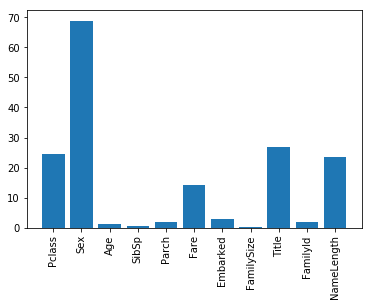

0.817059483726


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId", "NameLength"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform them from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores  
# Do you see how "Pclass", "Sex", "Title", and "Fare" are the best features?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the four best features
predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=8, min_samples_leaf=4)
# Compute the accuracy score for all the cross-validation folds; this is much simpler than what we did before
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

# Making predictions with multiple classifiers
One thing we can do to improve the accuracy of our predictions is ensemble different classifiers. Ensembling means generating predictions based on information from a set of classifiers, instead of just one. In practice, this means that we average their predictions.

Generally speaking, the more diverse the models we ensemble, the higher our accuracy will be. Diversity means that the models generate their results from different columns, or use very different methods to generate predictions. Ensembling a random forest classifier with a decision tree probably won't work extremely well, because they're very similar. On the other hand, ensembling a linear regression with a random forest can yield very good results.

One caveat with ensembling is that the classifiers we use have to be about the same in terms of accuracy. Ensembling one classifier that's much less accurate than the other will probably make the final result worse.

In this case, we'll ensemble logistic regression we trained on the most linear predictors (the ones that have a linear order, as well as some correlation to Survived) with a gradient-boosted tree we trained on all of the predictors.

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# The algorithms we want to ensemble
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# Initialize the cross-validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold 
        # We need to use .astype(float) to convert the dataframe to all floats and avoid an sklearn error
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme&#8212;just average the predictions to get the final classification
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.278338945006


# Making changes to the test sets

In [41]:
# First, we'll add titles to the test set
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles
# Check the counts of each unique title
print(pd.value_counts(titanic_test["Title"]))

# Now we add the family size column
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# Now we can add family IDs
# We'll use the same IDs we used earlier
print(family_id_mapping)

family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
Name: Title, dtype: int64
{'Braund1': 1, 'Cumings1': 2, 'Heikkinen0': 3, 'Futrelle1': 4, 'Allen0': 5, 'Moran0': 6, 'McCarthy0': 7, 'Palsson4': 8, 'Johnson2': 9, 'Nasser1': 10, 'Sandstrom2': 11, 'Bonnell0': 12, 'Saundercock0': 13, 'Andersson6': 14, 'Vestrom0': 15, 'Hewlett0': 16, 'Rice5': 17, 'Williams0': 18, 'Vander Planke1': 19, 'Masselmani0': 20, 'Fynney0': 21, 'Beesley0': 22, 'McGowan0': 23, 'Sloper0': 24, 'Asplund6': 25, 'Emir0': 26, 'Fortune5': 27, "O'Dwyer0": 28, 'Todoroff0': 29, 'Uruchurtu0': 30, 'Spencer1': 31, 'Glynn0': 32, 'Wheadon0': 33, 'Meyer1': 34, 'Holverson1': 35, 'Mamee0': 36, 'Cann0': 37, 'Vander Planke2': 38, 'Nicola-Yarred1': 39, 'Ahlin1': 40, 'Turpin1': 41, 'Kraeff0': 42, 'Laroche3': 43, 'Devaney0': 44, 'Rogers0': 45, 'Lennon1': 46, "O'Driscoll0": 47, 'Samaan2': 48, 'Arnold-Franchi1': 49, 'Panula5': 50, 'Nosworthy0': 51, 'Harper1': 52, 'Faunthorpe1': 53, 'Ostby1': 54, 'Woolner0': 55, 'R

# Predicting on the test set


In [42]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4

# Conclusion
There's still more work I could have done in feature engineering:

- Try using features related to the cabins.
- See if any family size features might help. Do the number of women in a family make the entire family more likely to survive?
- Does the national origin of the passenger's name have anything to do with survival?

There's also a lot more we can do on the algorithm side:

- Try the random forest classifier in the ensemble.
- A support vector machine might work well with this data.
- We could try neural networks.
- Boosting with a different base classifier might work better.

And with ensembling methods:

- Could majority voting be a better ensembling method than averaging probabilities?
